In [1]:
## Train a model to classify the images
#
## Import libraries

import os
import numpy as np

from tensorflow import keras
np.random.seed(0)

import src.config as config
from src.dataloader import read_train, read_val
from src.preprocessing import CustomDataGenerator
from src.results import plot_history, plot_cm, class_report,\
                            save_params, write_summary
from src.utils import setup_logger, header
import argparse
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


RAW_DATA_PATH = 'input/data/raw'
META_PATH = 'input/metadata/'

## Set up constants
LEARNING_RATE = .00001
BATCH_SIZE = 64
EPOCHS = 15
EXPNAME = "experiment"
EVENTNAME = f"lr_{LEARNING_RATE}_bs_{BATCH_SIZE}_ep_{EPOCHS}"
OUTPUT_FOLDER = "notebooks/experiments/augmentation_3conv_3dense/output"


#Readind data directly from the csv file and raw images in order to use data augmentation
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
df_labels['label'] = df_labels['label'].str.strip()
df_info = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
df_info["Medium"] = df_info["Medium"].str.strip()
df_load_data = df_info.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'Medium']]

df_load_data

2023-11-05 13:17:20.282567: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 13:17:20.305060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 13:17:20.631350: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Image file,Subset,Medium
0,436018.jpg,train,Oil on canvas
1,11779.jpg,train,Oil on canvas
2,19022.jpg,train,Oil on canvas
3,435883.jpg,train,Oil on canvas
4,10481.jpg,train,Oil on canvas
...,...,...,...
37402,261318.jpg,test,Albumen photograph
37403,646703.jpg,test,Albumen photograph
37404,417445.jpg,test,Albumen photograph
37405,646328.jpg,test,Albumen photograph


In [2]:

datagen = ImageDataGenerator(
                                rotation_range=30,        # Random rotation between -30 and 30 degrees
                                width_shift_range=0.125,    # Random horizontal shifting (crop)
                                height_shift_range=0.125,   # Random vertical shifting (crop)
                                horizontal_flip=True,     # Randomly flip images horizontally
                                rescale=1./255.,          # Rescale pixel values to the range [0, 1]
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation

)

val_datagen = ImageDataGenerator(rescale=1./255.,
                                # preprocessing_function=lambda x: center_crop(x, 200, 200),
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation
)
# val_datagen.mean = 0.5
# val_datagen.std = 0.5

# val_datagen.mean = 0.5795
# val_datagen.std = 4.22
# df_load_data['id'] = df_load_data['id'].astype('str') # requires target in string format

train_generator_df = datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'train'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)

val_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)


test_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'],
                                                    directory=RAW_DATA_PATH,
                                                    x_col="Image file", 
                                                    y_col="Medium",
                                                    class_mode="sparse",
                                                    target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=2020)

y_val = val_generator_df.classes
labels = list(train_generator_df.class_indices.keys())

## Define architecture
layers = [
        
        keras.Input(shape=(config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS)),
        keras.layers.Conv2D(64,(3,3), activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),
        keras.layers.Conv2D(128,(3,3), activation = 'relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),
        keras.layers.Conv2D(256,(3,3), activation = 'relu'),
        keras.layers.MaxPooling2D(pool_size = (4, 4)),

        keras.layers.Flatten(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(29, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.


2023-11-05 13:17:22.968048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 13:17:22.983269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-05 13:17:22.983398: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
## Train model
model.fit(train_generator_df,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=val_generator_df)

Epoch 1/15


2023-11-05 13:17:28.980519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-05 13:17:29.035520: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-05 13:17:29.035533: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-05 13:17:29.035569: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-05 13:17:29.409483: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


318/318 [==============================] - 108s 334ms/step - loss: 3.1724 - accuracy: 0.1380 - val_loss: 3.2493 - val_accuracy: 0.1317
Epoch 2/15
318/318 [==============================] - 106s 334ms/step - loss: 2.6827 - accuracy: 0.2586 - val_loss: 2.5415 - val_accuracy: 0.3076
Epoch 3/15
318/318 [==============================] - 107s 335ms/step - loss: 2.4188 - accuracy: 0.3221 - val_loss: 2.3100 - val_accuracy: 0.3566
Epoch 4/15
318/318 [==============================] - 106s 334ms/step - loss: 2.2213 - accuracy: 0.3702 - val_loss: 2.2079 - val_accuracy: 0.3745
Epoch 5/15
318/318 [==============================] - 106s 334ms/step - loss: 2.0876 - accuracy: 0.3994 - val_loss: 2.1019 - val_accuracy: 0.4055
Epoch 6/15
318/318 [==============================] - 107s 335ms/step - loss: 1.9837 - accuracy: 0.4274 - val_loss: 2.0265 - val_accuracy: 0.4276
Epoch 7/15
318/318 [==============================] - 106s 333ms/step - loss: 1.8962 - accuracy: 0.4463 - val_loss: 1.9500 - val_accura

In [8]:
model.evaluate(test_generator_df)

23/23 [==============================] - 1s 56ms/step - loss: 1.7176 - accuracy: 0.5062


[1.7176340818405151, 0.5062068700790405]

23/23 [==============================] - 1s 56ms/step


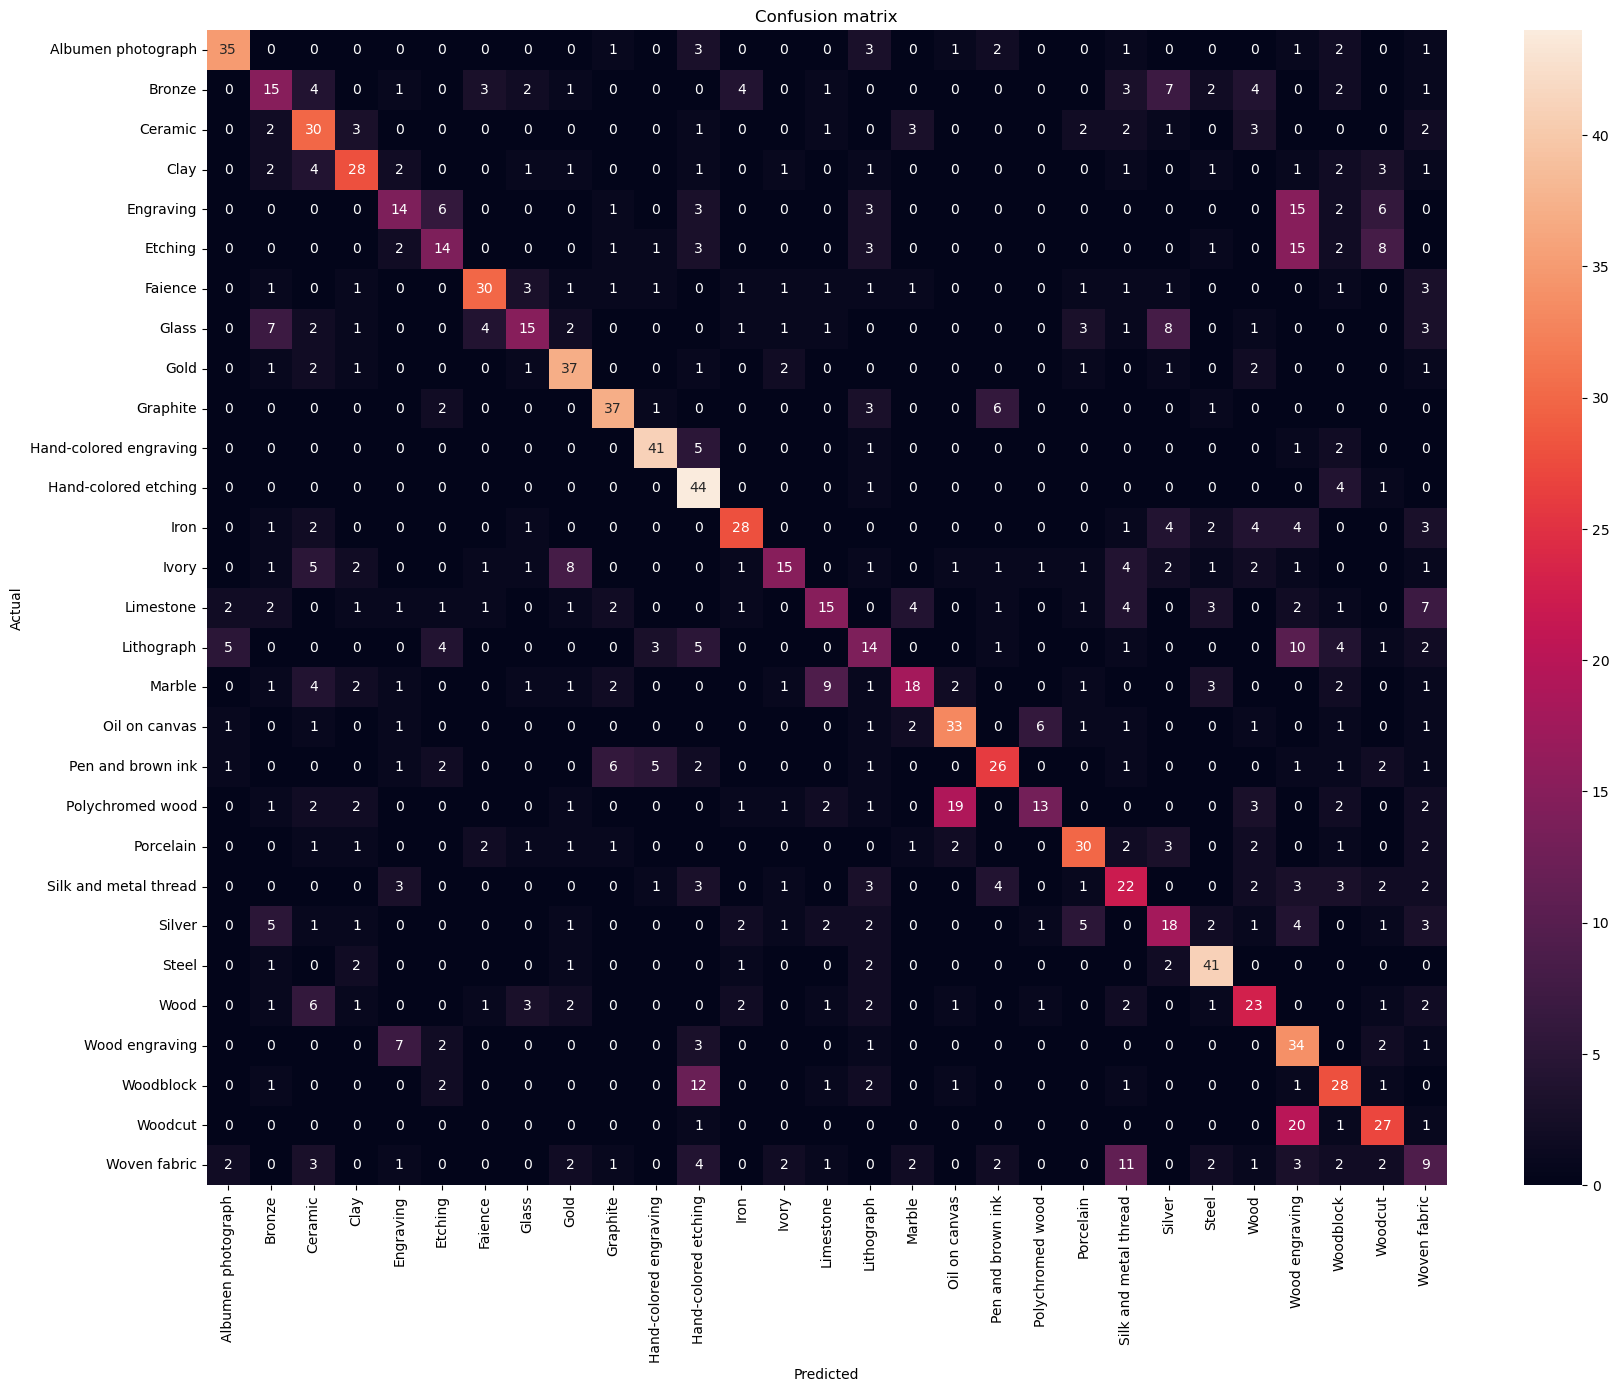

In [4]:
from src.results import plot_history, plot_cm, class_report

y_pred = model.predict(test_generator_df)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_generator_df.labels

plot_cm(y_true, y_pred, df_labels.label.unique());

In [7]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_aggregate_exact_metrics',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_get_config',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_graph_network_for_inferred_shape',
 '_build_input_shape',
 '_call_spec',
 '_callable_losses',
 '_captured_weight_regularizer',
 '_cast_single_input',
 '_check

In [78]:
model.history.history

{}

KeyError: "None of [Index(['accuracy', 'val_accuracy'], dtype='object')] are in the [columns]"

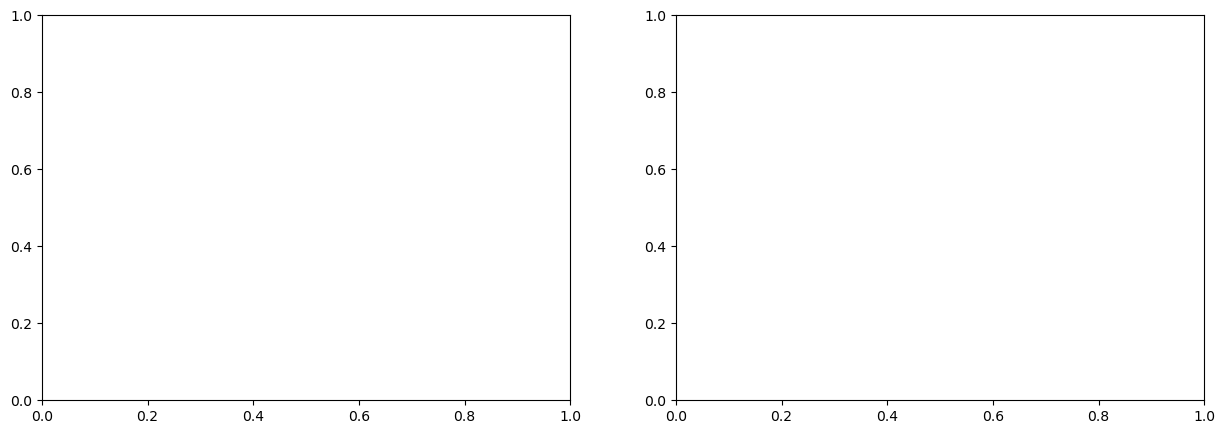

In [5]:
df_hist = model.history.history
df_hist = pd.DataFrame(df_hist)

fig, ax = plt.subplots(1,2, figsize=(15,5))
df_hist[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df_hist[['loss', 'val_loss']].plot(ax=ax[1])

# No augmentation

<Axes: >

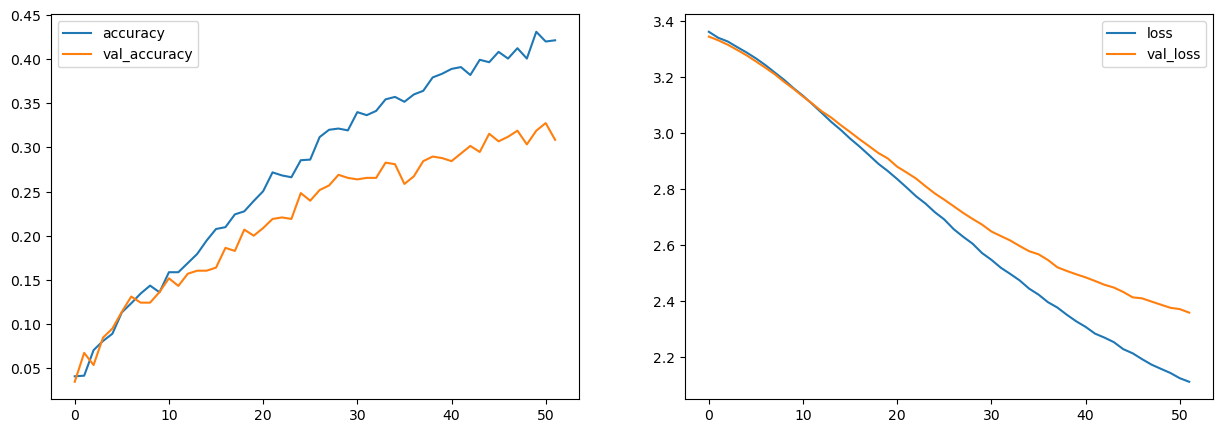

In [51]:
df_hist = model.history.history
df_hist = pd.DataFrame(df_hist)

fig, ax = plt.subplots(1,2, figsize=(15,5))
df_hist[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df_hist[['loss', 'val_loss']].plot(ax=ax[1])

In [30]:
# Calculate channel wise average for the pictures in X_train
channelwise_average = np.mean(X_train, axis=(0, 1, 2))

In [31]:
channelwise_average

array([157.87659182, 149.63594474, 138.00420135])

In [29]:
X_train.mean(axis=3)

array([[[237.66666667, 236.66666667, 234.66666667, ..., 209.        ,
         207.        , 206.        ],
        [235.66666667, 235.66666667, 236.66666667, ..., 209.        ,
         208.        , 207.        ],
        [231.66666667, 234.66666667, 238.66666667, ..., 210.        ,
         209.        , 208.        ],
        ...,
        [218.        , 219.        , 219.        , ..., 188.66666667,
         190.66666667, 192.66666667],
        [220.        , 218.        , 217.        , ..., 187.66666667,
         189.66666667, 190.66666667],
        [221.        , 218.        , 215.        , ..., 187.66666667,
         188.66666667, 189.66666667]],

       [[223.33333333, 225.33333333, 229.        , ..., 189.66666667,
         190.33333333, 233.33333333],
        [225.33333333, 223.        , 223.        , ..., 189.66666667,
         191.33333333, 235.33333333],
        [231.        , 226.33333333, 222.33333333, ..., 190.66666667,
         192.33333333, 236.        ],
        ...,


In [26]:
X_train.mean(axis=)

array([[[[210, 249, 254],
         [209, 248, 253],
         [207, 246, 251],
         ...,
         [171, 218, 238],
         [169, 216, 236],
         [168, 215, 235]],

        [[208, 247, 252],
         [208, 247, 252],
         [209, 248, 253],
         ...,
         [171, 218, 238],
         [170, 217, 237],
         [169, 216, 236]],

        [[204, 243, 248],
         [207, 246, 251],
         [211, 250, 255],
         ...,
         [172, 219, 239],
         [171, 218, 238],
         [170, 217, 237]],

        ...,

        [[188, 223, 243],
         [189, 224, 244],
         [189, 224, 244],
         ...,
         [153, 192, 221],
         [155, 194, 223],
         [157, 196, 225]],

        [[190, 225, 245],
         [188, 223, 243],
         [187, 222, 242],
         ...,
         [152, 191, 220],
         [154, 193, 222],
         [155, 194, 223]],

        [[191, 226, 246],
         [188, 223, 243],
         [185, 220, 240],
         ...,
         [152, 191, 220],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

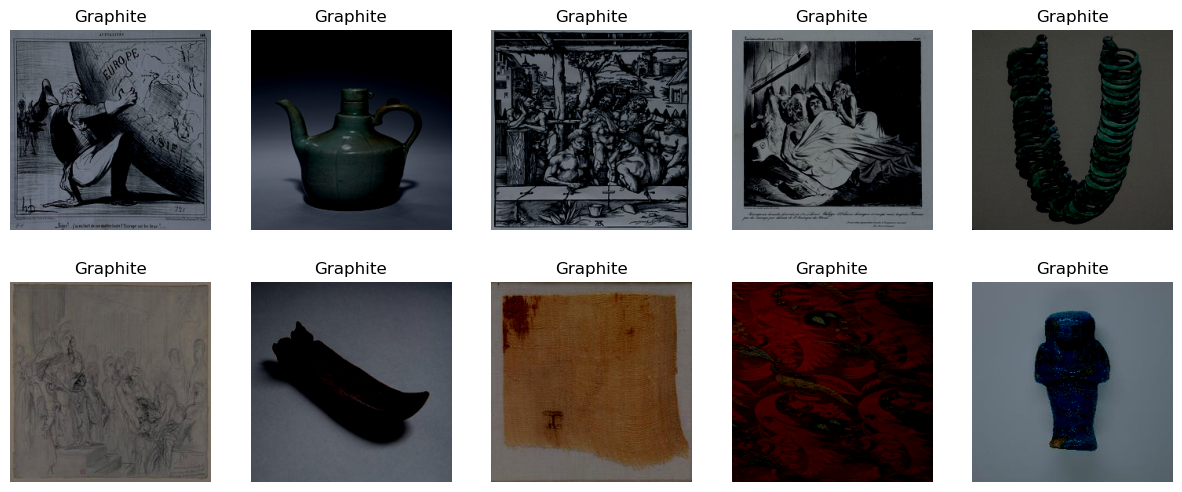

In [20]:
# show some images
img = val_generator_df.next()[0]

fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i])
    plt.title(config.LABELS[y_val[i]])
    plt.axis('off')

In [40]:
y_pred = model.predict(test_generator_df)
y_pred = np.argmax(y_pred, axis=1)
y_pred

6/6 [==============================] - 3s 516ms/step


array([18, 26,  0, ...,  0,  0, 18])

In [42]:
y_val

array([], dtype=int64)

In [11]:
# load model
model_file = os.path.join("output/data_augmentation/lr_1e-05_bs_128_ep_50/model.h5")
model = keras.models.load_model(model_file)
model.evaluate_generator(val_generator_df)

/tmp/ipykernel_57903/3091770916.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(val_generator_df)


[1.4691064357757568, 0.5600000023841858]

In [32]:
model.predict_generator(val_generator_df)

/tmp/ipykernel_57903/1491914246.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model.predict_generator(val_generator_df)


array([[6.41905610e-03, 8.50712880e-04, 2.58025946e-03, ...,
        1.67243425e-02, 7.27235689e-04, 1.07015349e-01],
       [1.46451581e-03, 1.04797361e-02, 3.65788266e-02, ...,
        3.38811334e-03, 3.96566520e-06, 1.20599859e-03],
       [3.69011774e-03, 1.88433056e-04, 3.26546980e-03, ...,
        1.21984398e-02, 4.74232854e-03, 4.08457875e-01],
       ...,
       [5.31327492e-03, 1.76465474e-02, 5.91372140e-03, ...,
        1.28656356e-02, 6.43487051e-02, 8.77647251e-02],
       [7.59855084e-06, 5.75876038e-04, 1.98159381e-04, ...,
        5.16010077e-05, 1.14534405e-05, 9.10807634e-04],
       [1.10735092e-03, 1.05643761e-03, 3.72240320e-04, ...,
        5.81212481e-03, 6.23891409e-03, 2.87269312e-03]], dtype=float32)

In [52]:
y_val.dtype

dtype('int64')

In [48]:
class_report(y_val, y_pred, config.LABELS)

/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

TypeError: expected str, bytes or os.PathLike object, not list

46/46 [==============================] - 3s 56ms/step


Text(95.72222222222221, 0.5, 'Actual')

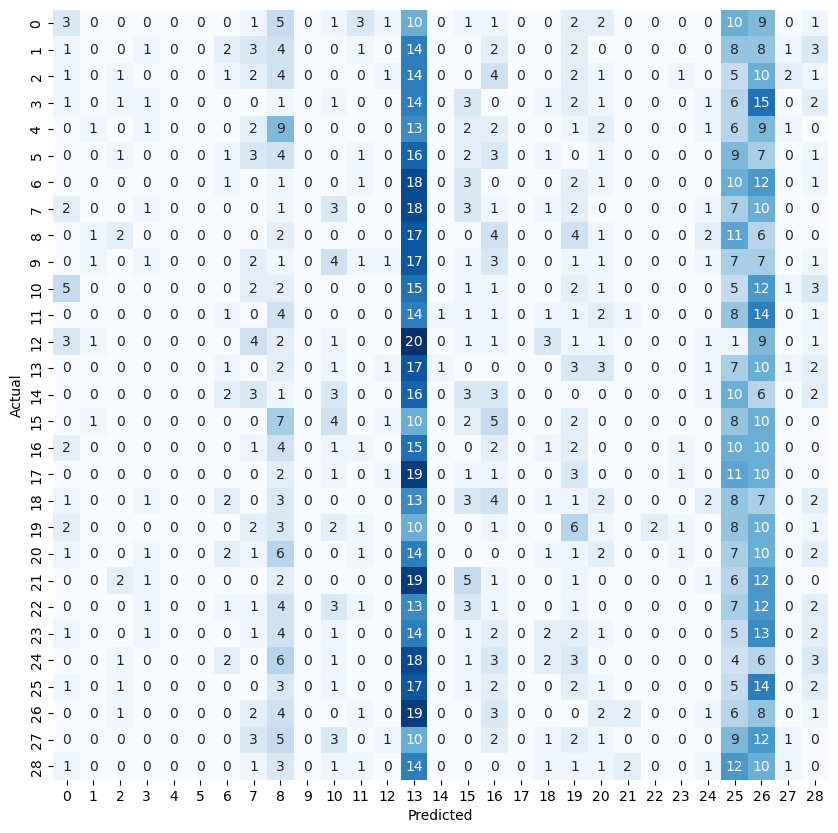

In [46]:
X_val, _ = read_val()
y_val = df_load_data[df_load_data['Subset'] == 'val']['id'].values.astype(int)
labels = list(train_generator_df.class_indices.keys())

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)

# plot_cm(y_val, y_pred, labels)

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')


In [35]:
y_val

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 26,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.02      0.02      0.02        50
           1       0.06      0.08      0.07        50
           2       0.03      0.02      0.02        50
           3       0.09      0.08      0.09        50
           4       0.00      0.00      0.00        50
           5       0.03      0.06      0.04        50
           6       0.05      0.04      0.04        50
           7       0.05      0.04      0.05        50
           8       0.00      0.00      0.00        50
           9       0.02      0.02      0.02        50
          10       0.04      0.04      0.04        50
          11       0.05      0.08      0.06        50
          12       0.06      0.06      0.06        50
          13       0.03      0.02      0.02        50
          14       0.06      0.04      0.05        50
          15       0.00      0.00      0.00        50
          16       0.08      0.04      0.05        50
          17       0.06    

1/1 [==============================] - 0s 18ms/step


Text(0.5, 1.0, 'Ivory')

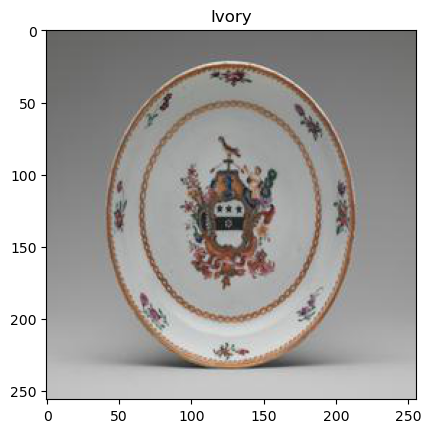

In [45]:
k = 35
img = X_val[k]
plt.imshow(img)
label = model.predict(img.reshape(1, 256, 256, 3))
label = np.argmax(label, axis=1)
label = config.LABELS[label[0]]
plt.title(label)

In [ ]:
# magic command to reload libraries
# %load_ext autoreload
# %autoreload 2

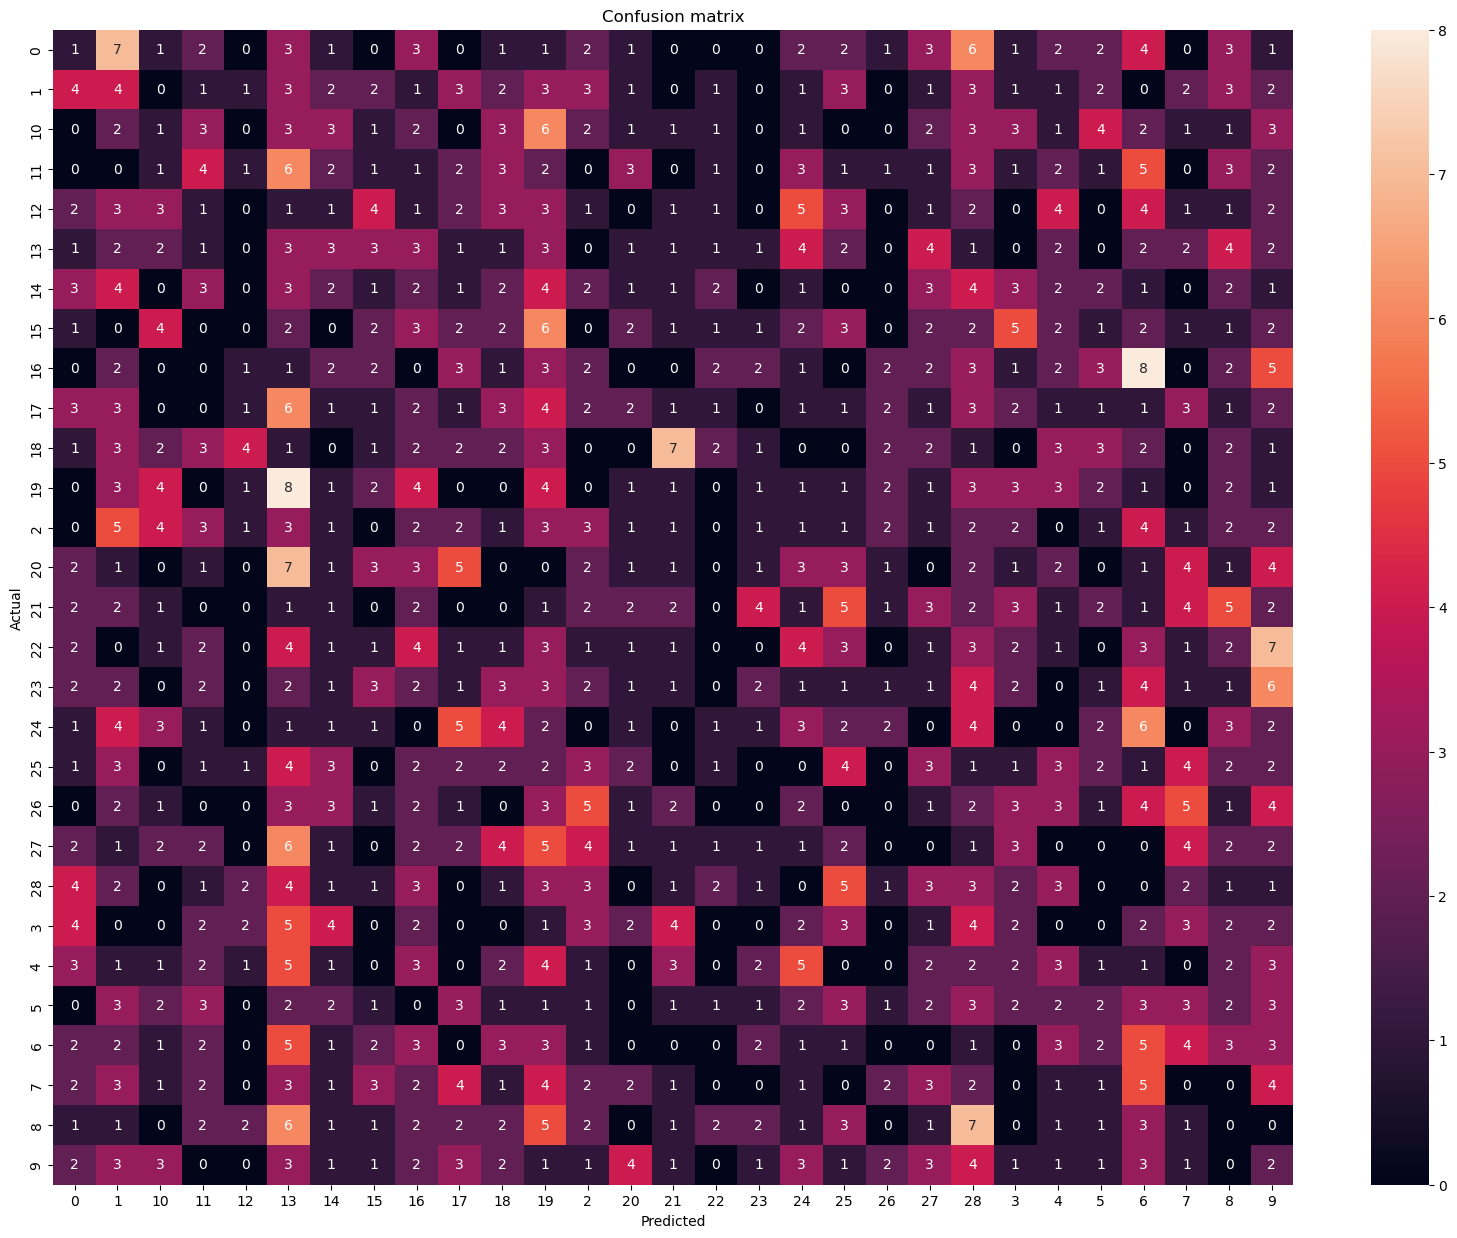

In [36]:
%load_ext autoreload
%autoreload 2

# y_train_pred = model.predict(train_generator_df)
# y_train_pred = np.argmax(y_train_pred, axis=1)
# y_train = train_generator_df.classes

from src.results import plot_cm
fig = plot_cm(y_val, y_pred, labels=labels)


In [50]:
## Get X_train and X_val from the generator
X_train = train_generator_df
X_val = list(val_generator_df)

len(X_val)

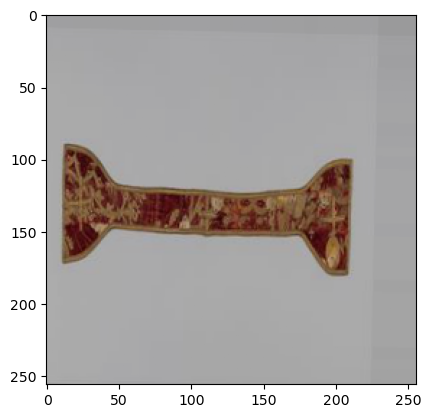

In [42]:
# Show the transformation always on the same image
img = train_generator_df[0][0][0]
plt.imshow(img)
plt.show()

In [37]:
df_load_data["Image file"].nunique()

37407

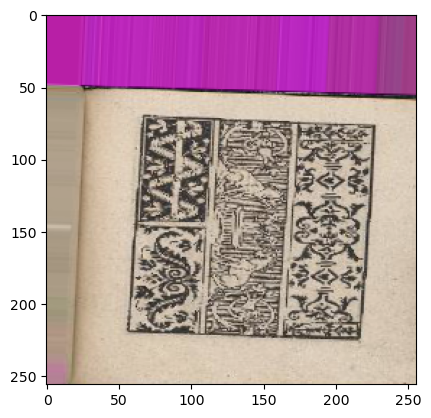

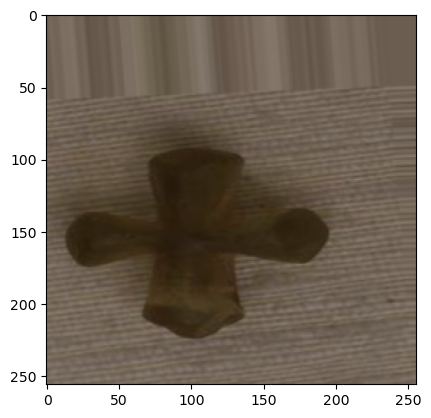

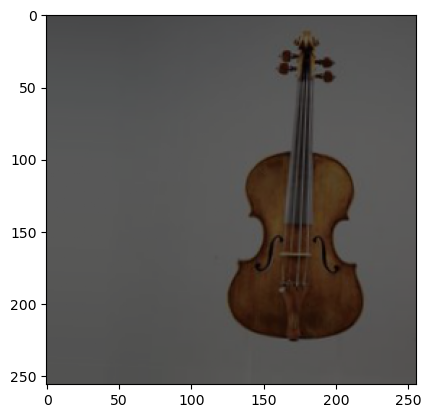

In [4]:
# Generate example images
x, y = next(train_generator_df)
for i in range(0, 3):
   image = x[i]
   plt.imshow(image)
   plt.show()
